In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignores all warnings


## DATA LOADINNG AND PREPROCESSING

In [2]:
import pandas as pd
data = pd.read_csv("TCS Historical Data.csv")
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,24-02-2025,"3,675.60","3,743.15","3,763.20","3,670.00",2.51M,-2.92%
1,21-02-2025,"3,786.00","3,776.10","3,817.00","3,775.00",1.83M,0.17%
2,20-02-2025,"3,779.40","3,761.50","3,788.00","3,751.30",2.89M,-0.12%
3,19-02-2025,"3,784.10","3,872.20","3,874.95","3,768.15",4.37M,-2.30%
4,18-02-2025,"3,873.20","3,898.40","3,924.40","3,864.50",2.15M,-0.80%


In [3]:
data = data[::-1]
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.set_index("Date")
data['Open'] = data['Open'].str.replace(',', '')  # Remove commas
data["Open"] = pd.to_numeric(data["Open"] , errors = "coerce")
data['Price'] = data['Price'].str.replace(',', '')  # Remove commas
data["Price"] = pd.to_numeric(data["Price"] , errors = "coerce")
data['High'] = data['High'].str.replace(',', '')  # Remove commas
data["High"] = pd.to_numeric(data["High"] , errors = "coerce")
data['Low'] = data['Low'].str.replace(',', '')  # Remove commas
data["Low"] = pd.to_numeric(data["Low"] , errors = "coerce")
data['Vol.'] = data['Vol.'].str.replace('M', '')  # Remove commas
data["Vol."] = pd.to_numeric(data["Vol."] , errors = "coerce")
data['Change %'] = data['Change %'].str.replace('%', '')  # Remove commas
data["Change %"] = pd.to_numeric(data["Change %"] , errors = "coerce")

In [4]:
import numpy as np
data["log_ret"] = np.log(data["Price"]/data["Price"].shift(1))
data = data.dropna()
data.head()

,Price,Open,High,Low,Vol.,Change %,log_ret
Date,,,,,,,
2020-01-02,2157.65,2179.95,2179.95,2149.20,2.38,-0.46,-0.004601
2020-01-03,2200.65,2164.00,2223.00,2164.00,4.66,1.99,0.019733
2020-01-06,2200.45,2205.00,2225.95,2187.90,3.02,-0.01,-0.000091
2020-01-07,2205.85,2200.50,2214.65,2183.80,2.43,0.25,0.002451
2020-01-08,2255.25,2205.00,2260.00,2202.05,5.20,2.24,0.022148


## Visualizing the price and log_ret time series

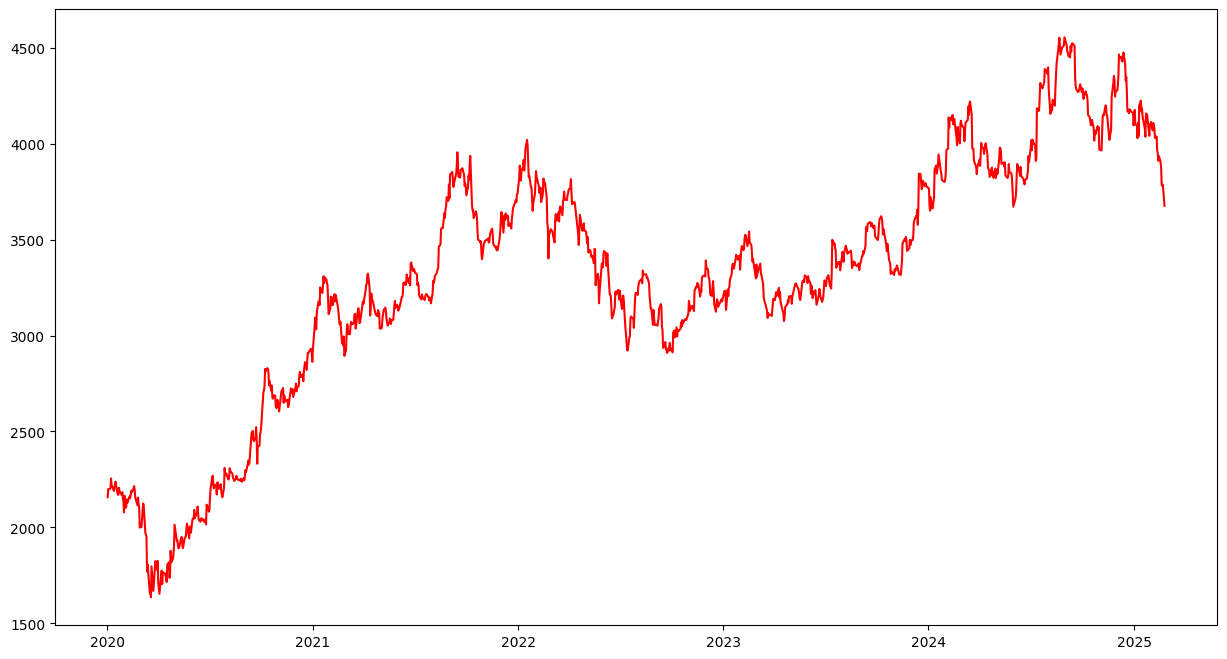

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
plt.plot(data["Price"] , color = "red")
plt.show()

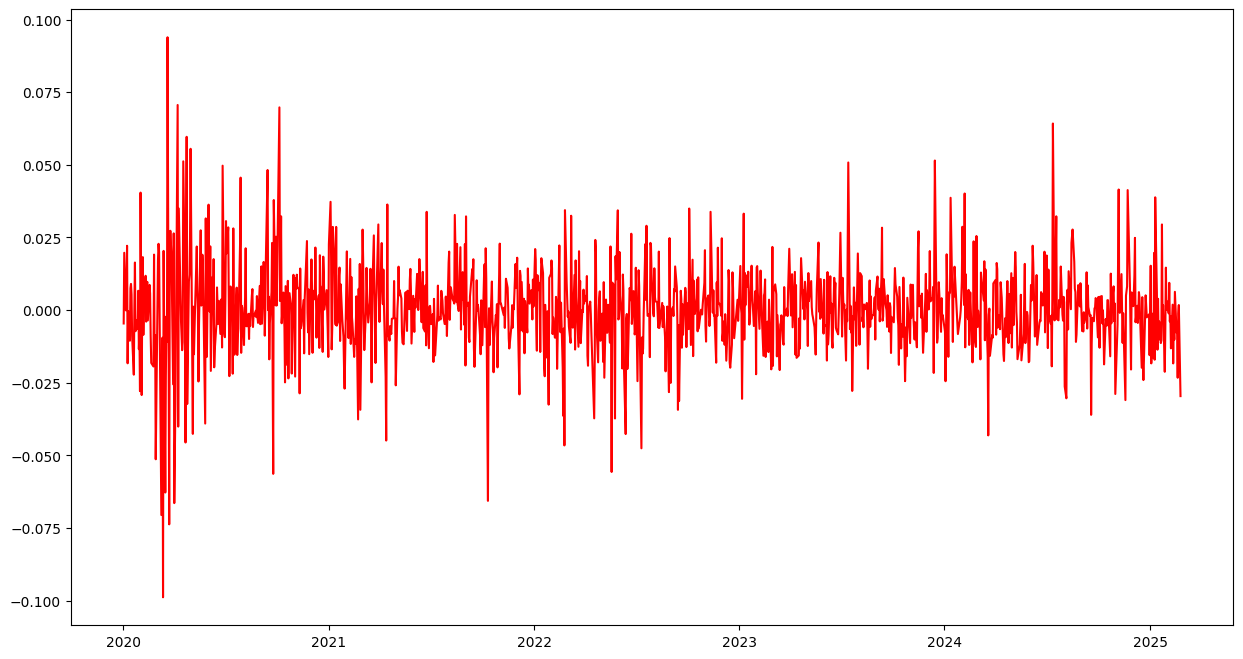

In [6]:
plt.figure(figsize = (15,8))
plt.plot(data["log_ret"] , color = "red")
plt.show()

## Format of prediction and using test train split

### my train window will be of 252 days and will test on next 21 days.. untill dataset exhausts

In [7]:
window_size = 252
test_size = 21

## Implementing ARIMA MODEL

In [8]:
import pandas as pd
import numpy as np
#import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


In [9]:
def arima( window_size , test_size , train_start):
    test_start = train_start + window_size
    train_set = data["log_ret"][train_start:train_start + window_size]
    test_set = data["log_ret"][test_start:test_start + test_size]
    rmse = 10000000
    a,b,c = 0,0,0
    for p in range(4):
        for d in range(1,2):
            for q in range(4):
                model = sm.tsa.ARIMA(train_set, order=(p, d, q))
                model = model.fit()
                n_forecast = len(train_set)
                # print("test dates length are" , n_forecast)
                forecast = model.forecast(steps =n_forecast)
                forecast.index = train_set.index
                temp = np.sqrt(mean_squared_error(train_set, forecast))
                # print("till now optimal parameters are:" , a , b , c , "and min rmse is: ", rmse)
                # print("for the values of p , d , q as:" ,p, d, q , "the rmse is:" ,temp)
                if temp < rmse:
                    rmse = temp
                    a = p
                    b = d
                    c = q 
    model = sm.tsa.ARIMA(train_set, order=(a, b, c))
    model = model.fit()
    n_forecast = len(test_set)
    forecast = model.forecast(steps =n_forecast)
    forecast.index=test_set.index
    #forecast = forecast*10
    # plt.figure(figsize = (14,6))
    # plt.plot(forecast, color = "blue")
    # plt.plot(test_set , color = "red")
    # plt.show()
    real_forecast =[]
    x = data["Price"][train_start + window_size]
    for i in range(21):
        val = np.exp(forecast[i])*x
        x = val
        real_forecast.append(val)
    # CALCULATING MAPE
    y_true, y_pred = np.array(data["Price"][test_start:test_start + test_size]), np.array(real_forecast)
    mape =  np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE formula
    print(f"MAPE: {mape:.4f}%")
    return mape
  
                             


In [10]:
train_date = []
for i in range(0,len(data),21):
    if i+252+21 > len(data)-1:
        break
    str1 = data.index[i].strftime("%Y-%m-%d")
    str2 = data.index[i+252].strftime("%Y-%m-%d")
    str = str1 + "to" + str2
    train_date.append(str)
valuation = pd.DataFrame(train_date, columns=['train_period'])
print(valuation)

              train_period
0   2020-01-02to2021-01-05
1   2020-01-31to2021-02-04
2   2020-03-02to2021-03-05
3   2020-04-01to2021-04-08
4   2020-05-07to2021-05-11
5   2020-06-08to2021-06-10
6   2020-07-07to2021-07-12
7   2020-08-05to2021-08-11
8   2020-09-03to2021-09-13
9   2020-10-05to2021-10-12
10  2020-11-03to2021-11-15
11  2020-12-04to2021-12-15
12  2021-01-05to2022-01-13
13  2021-02-04to2022-02-14
14  2021-03-05to2022-03-16
15  2021-04-08to2022-04-19
16  2021-05-11to2022-05-19
17  2021-06-10to2022-06-17
18  2021-07-12to2022-07-18
19  2021-08-11to2022-08-19
20  2021-09-13to2022-09-20
21  2021-10-12to2022-10-20
22  2021-11-15to2022-11-23
23  2021-12-15to2022-12-22
24  2022-01-13to2023-01-30
25  2022-02-14to2023-03-01
26  2022-03-16to2023-04-03
27  2022-04-19to2023-05-09
28  2022-05-19to2023-06-08
29  2022-06-17to2023-07-11
30  2022-07-18to2023-08-09
31  2022-08-19to2023-09-11
32  2022-09-20to2023-10-12
33  2022-10-20to2023-11-17
34  2022-11-23to2023-12-19
35  2022-12-22to2024-01-19
3

In [11]:
mape = []
for i in range(0,len(data),21):
    if i+252+21 > len(data)-1:
        break
    ans = arima(252 , 21 , i)
    mape.append(ans)
valuation["arima_bruteforce"] = mape    
valuation
    


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will 

MAPE: 2.1916%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 6.5476%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.8960%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 8.1716%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.1074%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.4041%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 0.9298%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 7.2032%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.8841%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 5.8234%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.7106%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.0182%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.8690%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 4.2679%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.3099%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.9406%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.6016%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.1874%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 7.5932%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 6.2443%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.1653%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.4431%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.9948%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.5498%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.9384%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 4.4819%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.1242%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.0638%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.1395%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 4.1185%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.1938%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.6153%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 4.5114%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.0695%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.7531%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.6519%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.6141%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.5337%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 1.3575%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.5316%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.9101%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.3689%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 3.4909%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 4.1752%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.8808%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 6.1321%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

MAPE: 2.0617%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,train_period,arima_bruteforce
0,2020-01-02to2021-01-05,2.191566
1,2020-01-31to2021-02-04,6.547566
2,2020-03-02to2021-03-05,1.895971
3,2020-04-01to2021-04-08,8.171557
4,2020-05-07to2021-05-11,2.107378
5,2020-06-08to2021-06-10,1.404136
6,2020-07-07to2021-07-12,0.929847
7,2020-08-05to2021-08-11,7.203229
8,2020-09-03to2021-09-13,2.884088
9,2020-10-05to2021-10-12,5.823373


In [15]:
valuation

,train_period,arima_bruteforce
0,2020-01-02to2021-01-05,2.191566
1,2020-01-31to2021-02-04,6.547566
2,2020-03-02to2021-03-05,1.895971
3,2020-04-01to2021-04-08,8.171557
4,2020-05-07to2021-05-11,2.107378
5,2020-06-08to2021-06-10,1.404136
6,2020-07-07to2021-07-12,0.929847
7,2020-08-05to2021-08-11,7.203229
8,2020-09-03to2021-09-13,2.884088
9,2020-10-05to2021-10-12,5.823373


## IMPLEMENTING SARIMA MODEL

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [25]:
def sarima_bruteforce(window_size , test_size , train_start):
    test_start = train_start + window_size
    train_set = data["log_ret"][train_start:train_start + window_size]
    test_set = data["log_ret"][test_start:test_start + test_size]
    rmse = 10000000
    a,b,c = 0,0,0
    for p in range(2,4):
        for d in range(2):
            for q in range(2,4):
                sarima_model = SARIMAX(train_set, order= (p,d,q), seasonal_order=(1,0,1,30))
                sarima_fit = sarima_model.fit()
                forecast = sarima_fit.predict(start= 0, end=len(train_set) -1, dynamic=False)
                forecast.index = train_set.index
                temp = np.sqrt(mean_squared_error(train_set, forecast))
                if temp < rmse:
                    rmse = temp
                    a = p
                    b = d
                    c = q 
    sarima_model = SARIMAX(train_set, order= (a,b,c), seasonal_order=(1,0,1,30))
    sarima_fit = sarima_model.fit()
    preds = sarima_fit.predict(start=len(train_set), end=len(train_set) + len(test_set)-1, dynamic=False) 
    real_forecast =[]
    x = data["Price"][train_start + window_size]
    for i in range(21):
        val = np.exp(preds.iloc[i])*x
        x = val
        real_forecast.append(val)  
    y_true, y_pred = np.array(data["Price"][test_start:test_start + test_size]), np.array(real_forecast)
    mape =  np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE formula
    print(f"MAPE: {mape:.4f}%")      
    return mape
           
    

In [26]:
mape = []
for i in range(0,len(data),21):
    if i+252+21 > len(data)-1:
        break
    ans = sarima_bruteforce(252 , 21 , i)
    mape.append(ans)
valuation["sarima_bruteforce"] = mape    
valuation

/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 2.0266%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 3.3648%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 2.4264%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 6.3921%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 1.2146%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 2.2324%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 1.4230%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 7.9001%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 1.4703%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 3.7630%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 1.3322%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 4.6051%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 2.8250%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 3.6743%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 1.7922%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 1.7898%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 2.7020%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 3.3109%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 6.1044%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 6.4763%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 1.1900%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 2.7987%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 1.9997%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 3.0825%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 1.8070%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 4.9740%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 1.1184%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 0.8715%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 1.1417%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 4.1621%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 1.0975%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 2.6705%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 3.9551%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 2.6515%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 1.4970%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 3.4108%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 1.5880%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 1.2479%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

MAPE: 1.0379%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 3.5243%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 4.3647%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 3.3514%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 2.6272%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 3.2717%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 2.9575%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated 

MAPE: 4.8341%


/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/linux/Documents/codes/btp_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so

MAPE: 1.8846%


,train_period,arima_bruteforce,sarima_bruteforce
0,2020-01-02to2021-01-05,2.191566,2.026598
1,2020-01-31to2021-02-04,6.547566,3.364802
2,2020-03-02to2021-03-05,1.895971,2.426362
3,2020-04-01to2021-04-08,8.171557,6.392070
4,2020-05-07to2021-05-11,2.107378,1.214597
5,2020-06-08to2021-06-10,1.404136,2.232371
6,2020-07-07to2021-07-12,0.929847,1.423049
7,2020-08-05to2021-08-11,7.203229,7.900123
8,2020-09-03to2021-09-13,2.884088,1.470315
9,2020-10-05to2021-10-12,5.823373,3.763023


In [28]:
valuation.to_csv("valuation.csv", index = False)

## IMPLEMENTING LSTM MODEL

In [ ]:
param = 25

In [ ]:
X = []
Y = []
Y = train_set[param:].to_list()
for i in range(len(train_set) - param):
    x = []
    x = train_set[i:i+param].to_list()
    X.append(x)
X = np.array(X)
print(X.shape) 
Y = np.array(Y)
print(Y.shape)

(227, 25)
(227,)


In [ ]:
X = X.reshape(X.shape[0] , X.shape[1],1)
X.shape

(227, 25, 1)

In [ ]:
# Define LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X.shape[0], 1)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss= "mse")

# Fit model
model.fit(X, Y, epochs=20, verbose=1)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 4.8256e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.1025e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9785e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.6833e-04
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8475e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.2793e-04
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.0128e-04
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.7122e-04
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.8119e-04
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.3679e-04
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.5104e-04
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.9432e-04
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.3473e-04
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.9349e-04
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

In [ ]:
x_input = train_set[len(train_set)-param:].to_list()
prediction = []
for i in range(len(test_set)):
    x = np.array(x_input).reshape(1,param,1)
    predict = model.predict(x)
    prediction.append(predict[0][0])
    x_input.append(predict[0][0])
    x_input.pop(0)
print(len(prediction))    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
21


In [ ]:
prediction = pd.Series(prediction)
prediction.index = test_set.index
print(prediction)

Date
2021-01-05    0.001154
2021-01-06    0.001153
2021-01-07    0.001152
2021-01-08    0.001152
2021-01-11    0.001152
2021-01-12    0.001152
2021-01-13    0.001152
2021-01-14    0.001152
2021-01-15    0.001153
2021-01-18    0.001153
2021-01-19    0.001154
2021-01-20    0.001154
2021-01-21    0.001155
2021-01-22    0.001155
2021-01-25    0.001156
2021-01-27    0.001156
2021-01-28    0.001156
2021-01-29    0.001157
2021-02-01    0.001157
2021-02-02    0.001157
2021-02-03    0.001157
dtype: float32


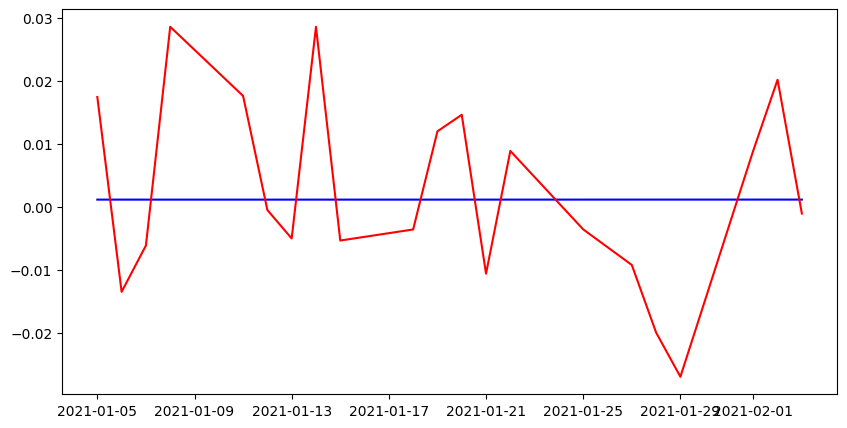

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(prediction , color = "blue")
plt.plot(test_set , color = "red")
plt.show()

## IMPLEMENTING RANDOM FOREST (predicting close price)

In [29]:
data["close"] = data["Open"].shift(-1)
data = data.dropna()
data.head()

,Price,Open,High,Low,Vol.,Change %,log_ret,close
Date,,,,,,,,
2020-01-02,2157.65,2179.95,2179.95,2149.20,2.38,-0.46,-0.004601,2164.00
2020-01-03,2200.65,2164.00,2223.00,2164.00,4.66,1.99,0.019733,2205.00
2020-01-06,2200.45,2205.00,2225.95,2187.90,3.02,-0.01,-0.000091,2200.50
2020-01-07,2205.85,2200.50,2214.65,2183.80,2.43,0.25,0.002451,2205.00
2020-01-08,2255.25,2205.00,2260.00,2202.05,5.20,2.24,0.022148,2248.75


In [30]:
rf_data = data[["Open" , "close"]]
print("lenghth of data = " , len(rf_data))

lenghth of data =  1249


In [33]:
# for t'th row (starting t from 242)
 #for m'th lag ( m = {1,2,3....20}U{40,60,80....240})
df = pd.DataFrame(columns=[f"col_{i}" for i in range(93)])
y_arr = []
for t in range(241,len(rf_data)):
    t_arr = []
    for m in range(1,21):
        ir_t_m = (rf_data["close"][t-m]/rf_data["Open"][t-m]) -1
        cr_t_m = (rf_data["close"][t-1]/rf_data["close"][t-1-m]) -1
        or_t_m = (rf_data["Open"][t]/rf_data["close"][t-m]) -1
        t_arr.append(ir_t_m)
        t_arr.append(cr_t_m)
        t_arr.append(or_t_m)

    for m in range(40,241,20):
        ir_t_m = (rf_data["close"][t-m]/rf_data["Open"][t-m]) -1
        cr_t_m = (rf_data["close"][t-1]/rf_data["close"][t-1-m]) -1
        or_t_m = (rf_data["Open"][t]/rf_data["close"][t-m]) -1
        t_arr.append(ir_t_m)
        t_arr.append(cr_t_m)
        t_arr.append(or_t_m)
        
    df.loc[len(df)] = t_arr  # Adds as a new row
    target = (rf_data["close"][t]/rf_data["Open"][t]) -1
    y_arr.append(target)
    
df["target"] = y_arr 



In [34]:
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,target
count,1008.000000,1008.000000,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,...,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,0.000390,0.000390,0.0,0.000397,0.000777,0.000390,0.000423,0.001180,0.000777,0.000424,...,0.000742,0.150000,0.149203,0.000714,0.164620,0.163899,0.000764,0.180061,0.179219,0.000361
std,0.013925,0.013925,0.0,0.013929,0.019199,0.013925,0.013899,0.022822,0.019199,0.013898,...,0.015702,0.217966,0.217325,0.015765,0.223679,0.223553,0.015675,0.230807,0.230144,0.013913
min,-0.045834,-0.045834,0.0,-0.045834,-0.056771,-0.045834,-0.045834,-0.088189,-0.056771,-0.045834,...,-0.113498,-0.243764,-0.244877,-0.113498,-0.213491,-0.215771,-0.113498,-0.240898,-0.259271,-0.045834
25%,-0.008640,-0.008640,0.0,-0.008640,-0.011288,-0.008640,-0.008617,-0.013697,-0.011288,-0.008617,...,-0.008575,0.012323,0.010076,-0.008685,0.006370,0.005671,-0.008533,0.009977,0.001855,-0.008685
50%,0.000000,0.000000,0.0,0.000000,0.000363,0.000000,0.000000,0.000129,0.000363,0.000000,...,0.000510,0.118017,0.115892,0.000514,0.149371,0.149287,0.000492,0.177485,0.174492,0.000000
75%,0.008860,0.008860,0.0,0.008882,0.012721,0.008860,0.008882,0.015792,0.012721,0.008882,...,0.010096,0.258799,0.247008,0.010113,0.270356,0.276251,0.010113,0.293288,0.291281,0.008856
max,0.064246,0.064246,0.0,0.064246,0.077512,0.064246,0.064246,0.076389,0.077512,0.064246,...,0.077412,0.993827,0.987562,0.077412,1.051003,1.061967,0.077412,0.933769,0.938193,0.064246


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming df is your dataset with 93 features and 1 target column
# Replace 'target_column' with the actual name of your target column
X = df.drop(columns=['target'])
y = df['target']

# Splitting the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# Initialize and train the Random Forest Regressor with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions
y_pred = rf_model.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


NameError: name 'model2df' is not defined

In [ ]:
y_test = np.array(y_test)

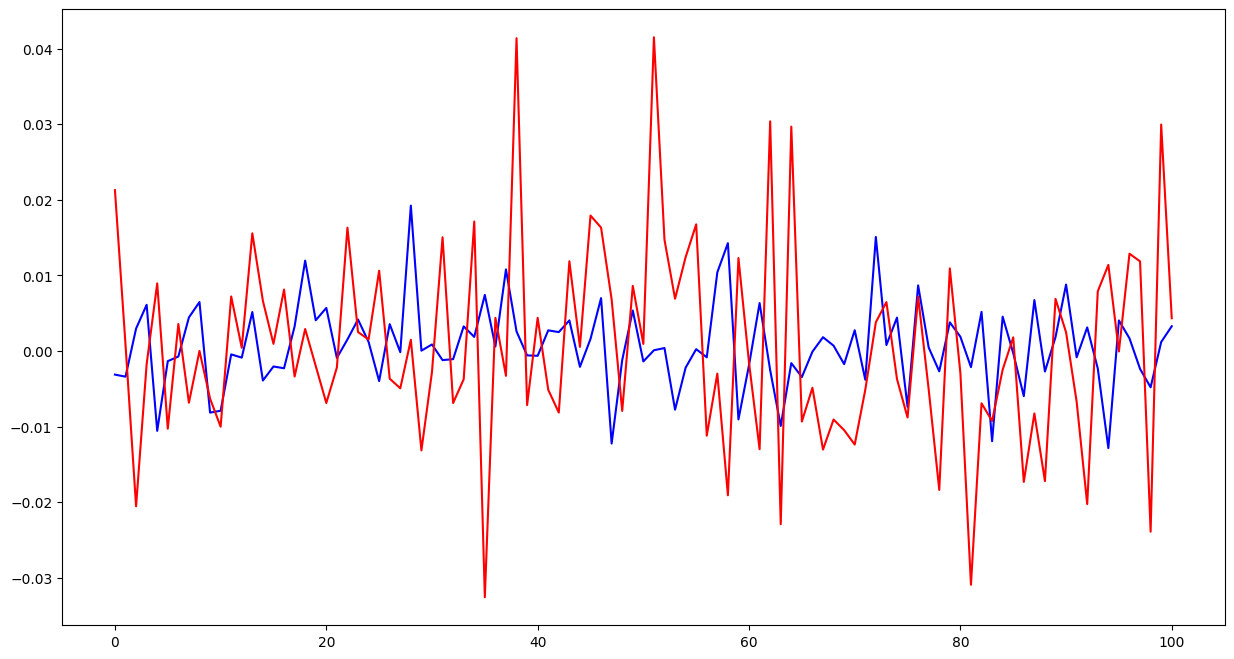

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(y_pred*2 , color = "blue")
plt.plot(y_test , color = "red")
plt.show()

## forecast using random forest for contineous 21 days

In [ ]:
len(df)

1008

In [ ]:
new_rf_data = data[["Open" , "close"]][241:]

In [ ]:
len(new_rf_data)

1008

In [ ]:

# Assuming df is your dataset
X = df.drop(columns=['target'])
y = df['target']

# Determine split index
split_idx = int(len(df) * 0.9)

# Manually split data sequentially
X_train, X_test = X.iloc[:745], X.iloc[745:]
y_train, y_test = y.iloc[:745], y.iloc[745:]

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
len(X_train)

745

In [ ]:
x = X_test[:1]
actual_close_pred = []
for i in range(len(X_train) ,767):
    y_pred = rf_model.predict(x)
    y_pred = y_pred*2
    actual_close = (y_pred+1)*new_rf_data["Open"][i]
    actual_close_pred.append(actual_close)
    new_rf_data["close"][i] = actual_close
    if i == len(df)-1:
        break
    new_rf_data["Open"][i+1] = actual_close
    t_arr = []
    for m in range(1,21):
        ir_t_m = (new_rf_data["close"][i+1-m]/new_rf_data["Open"][i+1-m]) -1
        cr_t_m = (new_rf_data["close"][i]/new_rf_data["close"][i-m]) -1
        or_t_m = (new_rf_data["Open"][i+1]/new_rf_data["close"][i+1-m]) -1
        t_arr.append(ir_t_m)
        t_arr.append(cr_t_m)
        t_arr.append(or_t_m)

    for m in range(40,241,20):
        ir_t_m = (new_rf_data["close"][i+1-m]/new_rf_data["Open"][i+1-m]) -1
        cr_t_m = (new_rf_data["close"][i]/new_rf_data["close"][i-m]) -1
        or_t_m = (new_rf_data["Open"][i+1]/new_rf_data["close"][i+1-m]) -1
        t_arr.append(ir_t_m)
        t_arr.append(cr_t_m)
        t_arr.append(or_t_m)
    x = pd.DataFrame(columns=[f"col_{i}" for i in range(93)])
    x.loc[len(x)] = t_arr  # Adds as a new row
    

    
    

In [ ]:
actual_close_pred = pd.Series(actual_close_pred)
actual_close_pred.index = rf_data["close"][986:986+22].index

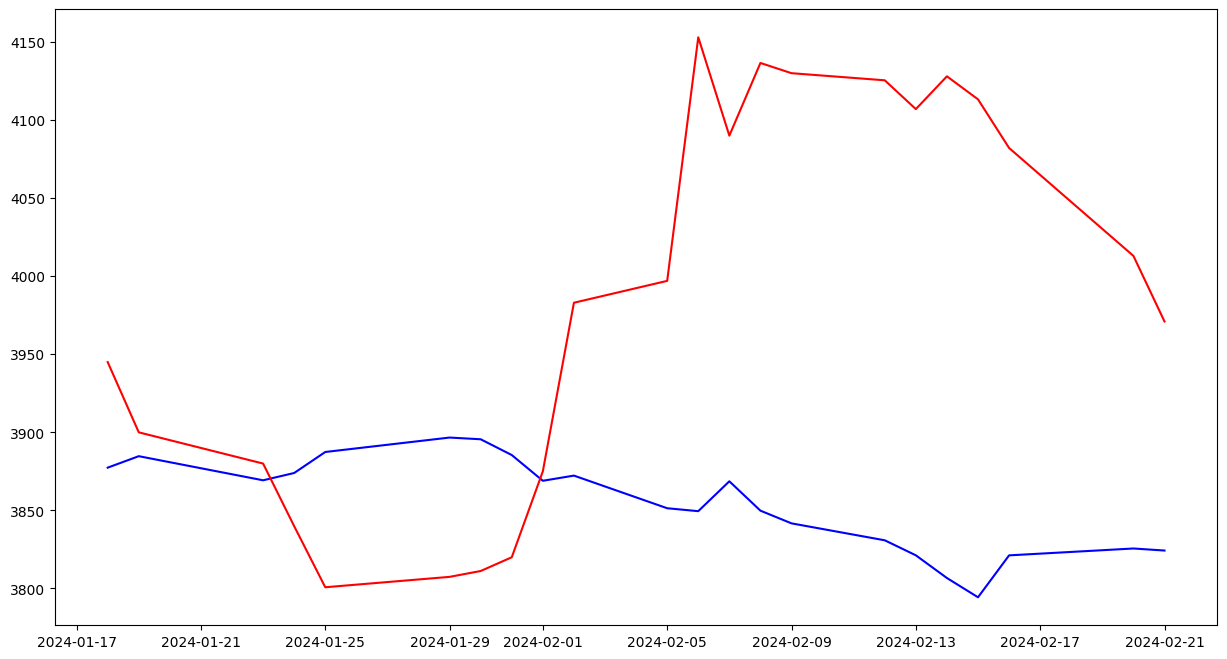

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(actual_close_pred , color = "blue")
plt.plot(rf_data["close"][986:986+22] , color = "red")
plt.show()

In [ ]:
# CALCULATING MAPE
y_true, y_pred = np.array(rf_data["close"][986:986+22]), np.array(actual_close_pred)
mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE formula
mape

array([4.06438033])